In [495]:
import cv2
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from scipy import ndimage

In [496]:
image = cv2.imread("./ampelmaennchen.png", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

enhancedImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [556]:
#Using Wikipedia Description for Normalization
arrayImage = (enhancedImage.astype('double') - np.min(enhancedImage.astype('double'))) / (np.max(enhancedImage.astype('double')) - np.min(enhancedImage.astype('double')))

In [557]:
#https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python/45764688#45764688
def gogFilter(sigma, xSize, ySize):
    
    xTemp = np.arange(-xSize/2+0.5, xSize/2)
    yTemp = np.arange(-ySize/2+0.5, ySize/2)
    
    XGrid, YGrid = np.meshgrid(xTemp, yTemp, sparse=True)
    gog = np.exp(-((XGrid**2 + YGrid**2) / (2*(sigma**2))))
    
    return gog/gog.sum()

In [558]:
derArray = np.array([2, 1, 0, -1, -2])
gauss = gogFilter(0.5, 1, 5)
filterX = derArray * gauss
#print(filterX)
#Transpose the fx Value using .T
filterY = filterX.T
#print(filterY)

In [559]:
imageX = ndimage.convolve(arrayImage, filterX)
imageY = ndimage.convolve(arrayImage, filterY)

gradMagnitude = np.sqrt(imageX**2 + imageY**2)

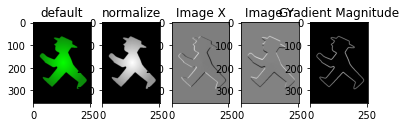

In [560]:
plt.subplot(1,5,1)
plt.imshow(image)
plt.title("default")

plt.subplot(1,5,2)
plt.imshow(arrayImage, cmap='gray')
plt.title("normalize")

plt.subplot(1,5,3)
plt.imshow(imageX, cmap='gray')
plt.title("Image X")

plt.subplot(1,5,4)
plt.imshow(imageY, cmap='gray')
plt.title("Image Y")

plt.subplot(1,5,5)
plt.imshow(gradMagnitude, cmap='gray')
plt.title("Gradient Magnitude")

plt.show()

In [563]:
#https://stackoverflow.com/questions/10571874/opencv-imwrite-saving-complete-black-jpeg
arrayImageNormed = 255 * (arrayImage - arrayImage.min()) / (arrayImage.max() - arrayImage.min())
arrayImageNormed = np.array(arrayImageNormed, np.int32)
cv2.imwrite("normalize.jpg", arrayImageNormed)

arrayImageXNormed = 255 * (imageX - imageX.min()) / (imageX.max() - imageX.min())
arrayImageXNormed = np.array(arrayImageXNormed, np.int32)
cv2.imwrite("Image X.jpg", arrayImageXNormed)

arrayImageYNormed = 255 * (imageY - imageY.min()) / (imageY.max() - imageY.min())
arrayImageYNormed = np.array(arrayImageYNormed, np.int32)
cv2.imwrite("Image Y.jpg", arrayImageYNormed)

arrayMagnitudeNormed = 255 * (gradMagnitude - gradMagnitude.min()) / (gradMagnitude.max() - gradMagnitude.min())
arrayMagnitudeNormed = np.array(arrayMagnitudeNormed, np.int32)
cv2.imwrite("Gradient Magnitude.jpg", arrayMagnitudeNormed)

#croppedImage because the array size is 355,255 so we change it to 255,255
croppedImage = arrayImage[50:305, 0:255]
croppedImageX = imageX[50:305, 0:255]
croppedImageY = imageY[50:305, 0:255]

In [551]:
def gogFilter5x5(arrSize, sigma):
    derArray = []
    arrSize = int(arrSize)//2
    for y in range(-arrSize, arrSize+1):
        gogArray =[]
        for x in range(-arrSize, arrSize+1):
            i = (1) / (2*np.pi*(sigma**2)) * np.exp(-1*((x**2)+(y**2)) / (2*(sigma**2)))
            gogArray.append(i)
        derArray.append(gogArray)
    derArray /= np.sum(derArray)
    return np.array(derArray)

filter2 = gogFilter5x5(5, 1)

array5x5 = np.ones((5, 5))

imageXX = np.multiply(imageX,imageX)
imageXY = np.multiply(imageX,imageY)
imageYY = np.multiply(imageY,imageY)

imageXX = ndimage.convolve(imageXX, filter2)
imageXY = ndimage.convolve(imageXY, filter2)
imageYY = ndimage.convolve(imageYY, filter2)

In [552]:
W = np.zeros((arrayImage.shape))
Q = np.zeros((arrayImage.shape))

In [553]:
"""
There must be a better way, since this cause some warning about the 0 division
"""
for i in range(0,arrayImage.shape[0], 1):
    for j in range(0,arrayImage.shape[1], 1):
        #print("i=", i, " j=", j)
        M = ([imageXX[i,j], imageXY[i,j]],[imageXY[i,j], imageYY[i,j]])
       
        #Calc Cornerness
        W[i,j] = np.linalg.det(M)/np.trace(M)
        #print(W[i,j])
        #Calc Roundness
        Q[i,j] = 4*np.linalg.det(M)/(np.trace(M)**2)
        #print(Q[i,j])

C:\Users\Lepiyao\AppData\Local\Temp\ipykernel_6060\3984106583.py:10: RuntimeWarning: invalid value encountered in double_scalars
  W[i,j] = np.linalg.det(M)/np.trace(M)
C:\Users\Lepiyao\AppData\Local\Temp\ipykernel_6060\3984106583.py:13: RuntimeWarning: invalid value encountered in double_scalars
  Q[i,j] = 4*np.linalg.det(M)/(np.trace(M)**2)


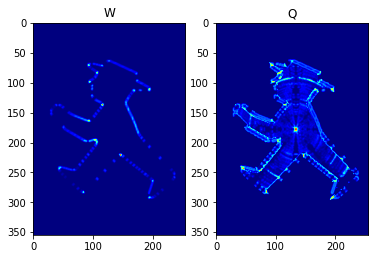

True

In [562]:
"""
replace nan with 0
https://datatofish.com/numpy-array-to-pandas-dataframe/
https://stackoverflow.com/questions/13295735/how-to-replace-nan-values-by-zeroes-in-a-column-of-a-pandas-dataframe    
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html
"""
df1 = pd.DataFrame(W).fillna(0)
W_Convert = df1.to_numpy()

df2 = pd.DataFrame(Q).fillna(0)
Q_Convert = df2.to_numpy()

# dstW_Convert = cv2.copyMakeBorder(W_Convert, 50, 50, 0, 0, cv2.BORDER_CONSTANT, None, 0)
# dstQ_Convert = cv2.copyMakeBorder(Q_Convert, 50, 50, 0, 0, cv2.BORDER_CONSTANT, None, 0)

plt.subplot(1,2,1)
plt.imshow(W_Convert, cmap='jet')
plt.title("W")

plt.subplot(1,2,2)
plt.imshow(Q_Convert, cmap='jet')
plt.title("Q")

plt.show()

arrayWNormed = 255 * (W_Convert - W_Convert.min()) / (W_Convert.max() - W_Convert.min())
arrayImageXNormed = np.array(arrayWNormed, np.int32)
cv2.imwrite("W image.jpg", arrayWNormed)

arrayQNormed = 255 * (Q_Convert - Q_Convert.min()) / (Q_Convert.max() - Q_Convert.min())
arrayQNormed = np.array(arrayQNormed, np.int32)
cv2.imwrite("Q image.jpg", arrayQNormed)

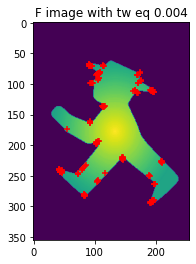

In [555]:
W_final = (W_Convert > 0.004)
Q_final = (Q_Convert > 0.5)

tlist1 = []
tlist2 = []

copyCroppedImage = arrayImage.copy()
for i in range(0,arrayImage.shape[0], 1):
    for j in range(0,arrayImage.shape[1], 1):
        if W_final[i,j] == True and Q_final[i,j] == True:
            tlist1.append(i)
            tlist2.append(j)

# with np.printoptions(threshold=np.inf):
#     print(tempArr)

plt.subplot(1,1,1)
plt.imshow(arrayImage)
plt.scatter(tlist2,tlist1, marker="+", color="red")
plt.title("F image with tw eq 0.004")
plt.savefig("F image with tw eq 0.004.jpg")

plt.show()